# Сортировка мусора
# Цель: 
Разработать модель для детеции пластиковых бутылок и других объектов на ленте конвейере
# Данные: 
- images - файл с 9000 изображениями, в них входят как тренировочные, так и тествоые изображения
- train.csv - файл с данными о названиях тренировочных изображений, о рамкамах объектов и класса объектов
- test.csv - файл с именами тестовых изображений
- sample_submission.csv - файл с примером сабмишина
# План:
- Изучение теории решения задач детекции
- Изучение данных
- Предобработка и исследовательский анализ данных
- Подбор модели и гиперпараметров

## Загрузка данных

In [1]:
!pip install -q --upgrade albumentations

In [2]:
!pip install -q ultralytics

In [3]:
import os
import pandas as pd
import torch
import cv2
import csv
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
from ast import literal_eval
import shutil
from albumentations.pytorch import ToTensorV2

from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
WIDTH = 2048
HEIGHT = 1486
RANDOM_STATE = 42

In [5]:
train_csv = '/kaggle/input/waste-detection/train.csv'
train_root = '/kaggle/input/waste-detection/images'

df = pd.read_csv(train_csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB


В датафрейме 3 столбца: file_name - названиея картинок, которые находятся в train_root, bbox- координаты боксов и category_id - класс объекта. В данных присутсвуют пропуски - изображения на которых нет объектов.

## Обработка и исследовательский анализ

       file_name                          bbox  category_id
2765  000856.jpg  [1006.0, 49.0, 286.0, 496.0]          1.0
2766  000856.jpg  [730.0, 158.0, 273.0, 506.0]          2.0
2767  000856.jpg  [986.0, 625.0, 229.0, 210.0]         13.0
2768  000856.jpg    [299.0, 0.0, 309.0, 191.0]          2.0


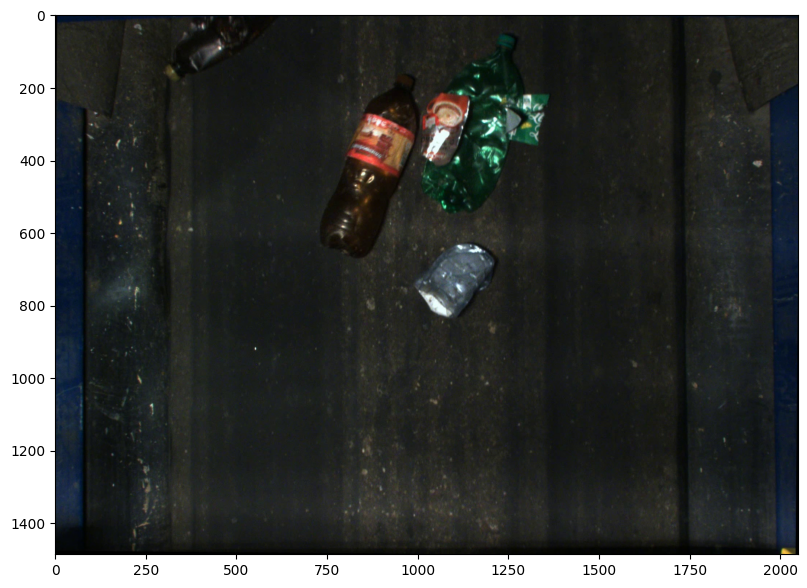

In [6]:
#Посмотрим на даныые
print(df[df['file_name'] == '000856.jpg'])

img_sample = mpimg.imread(os.path.join(train_root, '000856.jpg'))
plt.subplots(figsize=(10,7))
plt.imshow(img_sample)
plt.show()

Каждый объект на картинке имеет отдельную строку в df.

In [7]:
#Проверяем количество пропущенных значений
df.isna().sum()

file_name        0
bbox           117
category_id    117
dtype: int64

In [8]:
df[df['bbox'].isnull()].sample()

file_name bbox  category_id
5070  001830.jpg  NaN          NaN

In [9]:
#Выведем картинку с пропущенными значениями в bbox и category_id
image_sample_nan = (os.path.join(train_root, '001914.jpg'))

img = mpimg.imread(image_sample_nan)
plt.subplots(figsize=(10,7))
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
#Проверим распределение классов объектов
class_distribution = df['category_id'].value_counts()
class_distribution

category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64

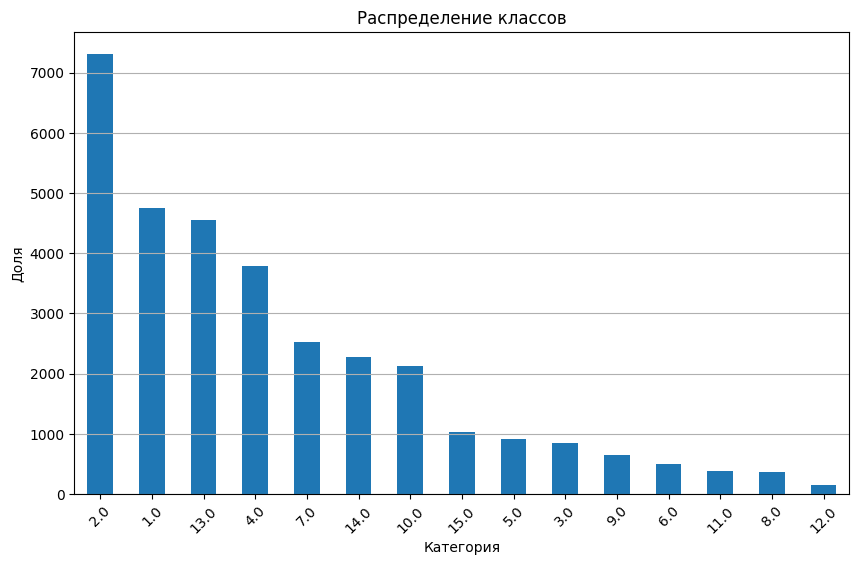

In [11]:
#Визуализируем распределение классов
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Категория')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

В данных наблюдается явный дисбаланс классов: встречается много объектов 2 и 1 категорий, мало - 12, 8 и 11

Была выдвинута гипотеза, что данные с пропущенными значениями в bbox и category_id важны для обучения модели, так как позволяют модели лучше понимать наличие объектов на изображении.

Аугментация данных должна помочь как с увеличением разнообразия данных, так и в борьбе с дисбалансом классов, т.к. можно аугментировать преимущественно классы с малым количеством примеров.

В качестве устранения дисбаланса классо можно также предложить:
- Ресемплирование
- Использование весов классов

Ресемплирование имеет несколько недостатков, при oversampling мы наполняем данными, которые не несут особой пользы, однако значительно поднимут затраты ресурсов на обучение моделей, при undersampling мы лишаем нас бльшого объема релевантных данных. 

In [12]:
#Удостоверяемся что все названия картинок что есть в датафрейме существуют в папке images
df_new = df[df['file_name'].apply(lambda x: os.path.exists(os.path.join(train_root, x)))]
df_new.shape

(32265, 3)

-----------------------------------------------------------------------------------------------------------------------

## Подготовка данных

In [13]:
# Создаем директории для данных
output_train_images = "/kaggle/working/yolo_data/train/images"
output_train_labels = "/kaggle/working/yolo_data/train/labels"
output_val_images = "/kaggle/working/yolo_data/val/images"
output_val_labels = "/kaggle/working/yolo_data/val/labels"
output_test_images = "/kaggle/working/yolo_data/test/images"

os.makedirs(output_train_images, exist_ok=True)
os.makedirs(output_train_labels, exist_ok=True)
os.makedirs(output_val_images, exist_ok=True)
os.makedirs(output_val_labels, exist_ok=True)
os.makedirs(output_test_images, exist_ok=True)


In [14]:
#Группируем данные по названиям изображений из-за того, что на одном изображении могут находится несколько объектов
grouped_df = df_new.groupby("file_name")
#Получаем список кортежей где каждому изображению соответсвуют его bbox и category_id
grouped_data = list(grouped_df)

#Перемешивание данных случайным образом
rng = np.random.default_rng(RANDOM_STATE)  
rng.shuffle(grouped_data)

#Разделение данных на тренировочные и валидационные 
train_frac = 0.9  
split_index = int(len(grouped_data) * train_frac)
train_groups = grouped_data[:split_index]
val_groups = grouped_data[split_index:]

#Возвращаем данные в датафреймы
train_df = pd.concat([group for _, group in train_groups], ignore_index=True)
val_df = pd.concat([group for _, group in val_groups], ignore_index=True)

In [15]:
def save_labels(df, images_output_path, labels_output_path):
    #Снова группируем по названию изображений
    grouped = df.groupby("file_name")  

    #Создаем аннотации для работы модели YoLo
    for file_name, group in grouped:
        #Путь к изображению
        image_path = os.path.join(train_root, file_name)
        #Путь к файлу аннотации для изображения
        label_path = os.path.join(labels_output_path, f"{os.path.splitext(file_name)[0]}.txt")
        
        if os.path.exists(image_path):
            #Cписок для хранения аннотаций для текущего изображения
            all_annotations = []
            try:
                #Перебираем данные в наших кортежах
                for _, row in group.iterrows():
                    # Учитываем наши изображения без объектов и просто пропускаем их
                    if pd.isna(row["bbox"]) or pd.isna(row["category_id"]):
                        continue

                    #Преобразование строки в список и извлечение параметров bbox
                    bbox = literal_eval(row["bbox"])
                    x, y, w, h = bbox

                    #Нормализация
                    x_center = (x + w / 2) / WIDTH
                    y_center = (y + h / 2) / HEIGHT
                    w_normalized = w / WIDTH
                    h_normalized = h / HEIGHT
                    
                    #Преобразуем номера классов, чтобы они начинались не с 1 а с 0, нужно для модели YoLo
                    category = row['category_id'] - 1

                    #Добавляем параметры bbox и класс объекта в список
                    all_annotations.append(f"{category} {x_center:.6f} {y_center:.6f} {w_normalized:.6f} {h_normalized:.6f}")
                
                #Запись аннотаций в файл
                with open(label_path, "w") as f:
                    f.write("\n".join(all_annotations)) 
                
                # Копирование изображений
                shutil.copy(image_path, images_output_path)
                
            except (ValueError, SyntaxError, KeyError) as e:
                print(f"Ошибка при парсинге рамок или отсутствуе данных: {file_name} ({e})")

In [16]:
#тренировочные данные
save_labels(train_df, output_train_images, output_train_labels)
#валидационные данные
save_labels(val_df, output_val_images, output_val_labels)

In [17]:
#Обработка тестовых данных
test_df = pd.read_csv("/kaggle/input/waste-detection/test.csv")
for _, row in test_df.iterrows():
    image_path = os.path.join(train_root, row["file_name"])
    if os.path.exists(image_path):
        shutil.copy(image_path, output_test_images)
    else:
        print(f"Skipping missing test image: {image_path}")

In [18]:
#Создание файла конфигурации в формате YAML для модели YoLo
data_yaml_path = '/kaggle/working/yolo_data/data.yaml'

data_yaml_content = f"""
train: /kaggle/working/yolo_data/train/images
val: /kaggle/working/yolo_data/val/images 
test: /kaggle/working/yolo_data/test/images

nc: 15 
names:
  0: PET (transparent) (green)
  1: PET (transparent) (brown)
  2: PET (transparent) (blue)
  3: PET (transparent)
  4: PET (transparent) (dark blue)
  5: PET (black)
  6: PET (white)
  7: PET (sticker)
  8: PET (flacon)
  9: PET (household chemicals)
  10: PND (household chemicals)
  11: PND packet
  12: Other plastic
  13: Other plastic (transparent)
  14: Not plastic
"""

#Запись в файл содержимое data_yaml_content, предварительно удаляя лишние пробелы и пустые строки
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content.strip())

## Обучение модели

In [19]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 68.8MB/s]


In [20]:
model.train(data='/kaggle/working/yolo_data/data.yaml', epochs=120, imgsz=(1024,768))

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]
2024-12-11 19:45:48,762	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-11 19:45:49,603	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/yolo_data/train/labels... 5400 images, 103 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:04<00:00, 1164.16it/s]


train: New cache created: /kaggle/working/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_data/val/labels... 601 images, 14 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<00:00, 1090.08it/s]

val: New cache created: /kaggle/working/yolo_data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      6.23G      0.893      2.855      1.068         76       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

                   all        601       3135      0.359        0.4      0.339      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      6.23G     0.8453      1.754      1.032         95       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all        601       3135      0.497       0.55      0.523      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      6.14G      0.863      1.533      1.044         69       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all        601       3135      0.557      0.498      0.503      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      6.08G     0.8596      1.378      1.048         82       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all        601       3135      0.582       0.62      0.616      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      6.21G     0.8344      1.201      1.039         93       1024: 100%|██████████| 338/338 [02:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135      0.711      0.642      0.695      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      6.18G      0.812      1.045      1.026         84       1024: 100%|██████████| 338/338 [02:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.793      0.673       0.76       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      6.18G     0.7896     0.9418      1.018         83       1024: 100%|██████████| 338/338 [02:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135      0.777       0.71      0.772      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      6.12G     0.7743     0.8752      1.014         73       1024: 100%|██████████| 338/338 [02:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.835      0.748      0.834      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       6.1G     0.7597     0.8083      1.004         70       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.899        0.8      0.884      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120       6.2G     0.7547     0.7761      1.003        100       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135       0.85      0.769      0.869      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      6.17G     0.7439     0.7293     0.9978         64       1024: 100%|██████████| 338/338 [02:39<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.904       0.79      0.885      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      6.07G     0.7325     0.7094     0.9944         58       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.913      0.805      0.893      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      6.21G     0.7221     0.6859     0.9896         92       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        601       3135      0.904      0.846      0.912      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      6.26G     0.7179     0.6588     0.9855        108       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.912      0.862      0.916      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      6.08G     0.7098     0.6442     0.9836         79       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135      0.952      0.844      0.919      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      6.37G     0.7042     0.6344     0.9827         56       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.952      0.868      0.934      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      6.28G     0.6977     0.6204     0.9822         78       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.934      0.855      0.927      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      6.21G     0.6906     0.6031     0.9779         77       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.947      0.844      0.918       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      6.29G     0.6834      0.597     0.9738         70       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.958      0.866      0.928      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      6.23G     0.6816     0.5816     0.9718         64       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135       0.95      0.872      0.926      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120       6.1G     0.6743     0.5792     0.9707         53       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.959      0.873      0.937      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      6.09G     0.6671     0.5593     0.9689         82       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135       0.97      0.875      0.934      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      6.26G     0.6705     0.5609     0.9691         65       1024: 100%|██████████| 338/338 [02:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.979      0.879      0.946      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      6.13G     0.6624     0.5462     0.9671         66       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.963      0.872      0.937      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      6.12G      0.655     0.5409     0.9615         83       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.962      0.891      0.945      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      6.15G     0.6494      0.531     0.9605         74       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.965      0.891      0.942       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      6.02G     0.6467     0.5217     0.9602         73       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.975      0.888      0.948       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      6.13G       0.64     0.5169     0.9573         94       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.968      0.895      0.949      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      6.21G     0.6366     0.5095     0.9579        108       1024: 100%|██████████| 338/338 [02:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.964      0.893      0.948      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120       6.1G     0.6347     0.5078     0.9556         79       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135      0.974      0.894      0.952      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      6.09G     0.6307     0.4981     0.9566         76       1024: 100%|██████████| 338/338 [02:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.975      0.899      0.947      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      6.13G     0.6297     0.4976      0.958         68       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.967      0.899      0.948      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120       6.1G     0.6272     0.4929     0.9555         60       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.953      0.903       0.95      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      6.06G     0.6257     0.4889     0.9512         85       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.964      0.904      0.948       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      6.12G     0.6198     0.4843     0.9509         46       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.972      0.903       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      6.06G     0.6207     0.4843     0.9517         71       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.971      0.918      0.958       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      6.07G     0.6164     0.4773     0.9486         87       1024: 100%|██████████| 338/338 [02:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135      0.979      0.909      0.952      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120       6.2G     0.6108     0.4737     0.9489         67       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        601       3135      0.966        0.9      0.948      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      6.13G     0.6105     0.4702      0.949         99       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.979       0.91      0.955      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      6.21G     0.6093     0.4656     0.9472         87       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.983      0.902      0.956      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      6.13G     0.6036      0.462     0.9469         50       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135      0.982      0.905      0.956      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      6.09G     0.5978     0.4554     0.9432         66       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        601       3135      0.977      0.917      0.957      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      6.15G     0.5987     0.4523     0.9454         72       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.981      0.914      0.956      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      6.23G     0.5932     0.4491      0.941         66       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

                   all        601       3135      0.985      0.906      0.956      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      6.13G     0.5917     0.4491     0.9397         97       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.977      0.913      0.957      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      6.19G     0.5891     0.4402     0.9412         92       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.985      0.908      0.958      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      6.22G     0.5909     0.4482     0.9423         78       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.974      0.922      0.961      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      6.23G     0.5849     0.4428     0.9398         76       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

                   all        601       3135      0.983      0.917       0.96      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      6.21G     0.5794     0.4323     0.9379        101       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.981      0.902      0.961      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      6.09G     0.5802     0.4316     0.9353         86       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135      0.982      0.919      0.961      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      6.13G     0.5787     0.4309     0.9354         65       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all        601       3135      0.987      0.915      0.961      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120       6.1G     0.5759     0.4245     0.9357        111       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        601       3135      0.977      0.924      0.962      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      6.09G     0.5785     0.4268     0.9368         68       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.986      0.916      0.958      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      6.21G     0.5677     0.4204     0.9321         77       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.976       0.92      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      6.12G     0.5699     0.4242      0.934         72       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.984      0.912      0.962      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      6.24G     0.5711     0.4187     0.9347         79       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.982      0.925      0.961      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      6.11G     0.5677     0.4145     0.9338         85       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.985      0.921       0.96      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      6.19G     0.5661     0.4134     0.9337         95       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135      0.987      0.916      0.961      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      6.12G     0.5593      0.405     0.9285         81       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135       0.98      0.932      0.963      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      6.12G     0.5568     0.4024     0.9277         75       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.983      0.925      0.962      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      6.19G     0.5605     0.4071     0.9313         72       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.988      0.917      0.963      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      6.27G     0.5565     0.4031     0.9277         68       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.988      0.918      0.961       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      6.03G     0.5564     0.4013     0.9267         62       1024: 100%|██████████| 338/338 [02:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.988      0.923      0.961      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      6.24G     0.5504     0.3999     0.9251         79       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.52it/s]

                   all        601       3135      0.979      0.929      0.962       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      6.06G     0.5501        0.4     0.9255         97       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.983      0.931       0.96       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      6.07G     0.5442     0.3927     0.9207         53       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.986      0.932      0.962      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120       6.2G      0.549     0.3984     0.9284         54       1024: 100%|██████████| 338/338 [02:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.982      0.925      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      6.11G     0.5442     0.3927     0.9232         80       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.978      0.932      0.963      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      6.15G     0.5388     0.3888     0.9197         99       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.977      0.934      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      6.12G     0.5417     0.3873     0.9216         66       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]

                   all        601       3135      0.977       0.94      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      6.17G     0.5348     0.3811     0.9192         60       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]

                   all        601       3135      0.986       0.93      0.965      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      6.37G     0.5352     0.3833     0.9181         57       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all        601       3135      0.978      0.935      0.964      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      6.13G     0.5361     0.3811      0.918         85       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135      0.986      0.926      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      6.09G     0.5286     0.3752     0.9151         83       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.985      0.929      0.963       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120       6.1G     0.5313     0.3756     0.9183         75       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.989      0.928      0.964      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      6.06G     0.5274     0.3745     0.9183         56       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135       0.98      0.931      0.964      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      6.19G     0.5276     0.3717     0.9167         63       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]

                   all        601       3135      0.987      0.928      0.966      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      6.13G     0.5262     0.3716     0.9162         77       1024: 100%|██████████| 338/338 [02:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]

                   all        601       3135      0.985      0.934      0.965      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      6.06G     0.5236     0.3681     0.9135         69       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.987      0.936      0.965       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120       6.3G     0.5206     0.3651     0.9158        108       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        601       3135      0.984      0.934      0.965      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      6.13G     0.5174     0.3643     0.9135         60       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.983      0.932      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      6.11G     0.5163     0.3638     0.9117         71       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.982      0.931      0.965      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      6.08G     0.5178     0.3626     0.9129         77       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.988      0.927      0.961      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      6.06G     0.5181     0.3635     0.9137         67       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all        601       3135      0.983      0.935      0.964       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      6.09G     0.5183     0.3607     0.9127         77       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.985      0.935      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      6.16G     0.5133     0.3576     0.9104        112       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        601       3135      0.987      0.938      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       6.1G     0.5128     0.3582     0.9103         85       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.985      0.936      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      6.14G     0.5146     0.3587     0.9142         76       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]

                   all        601       3135      0.985      0.933      0.964      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      6.09G     0.5064     0.3501     0.9084         39       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135      0.984      0.935      0.964      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      6.12G      0.505     0.3513     0.9085        104       1024: 100%|██████████| 338/338 [02:47<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.983      0.935      0.964      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      6.21G     0.5032     0.3503     0.9074         71       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135      0.985      0.936      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      6.13G     0.5038      0.348     0.9068         67       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.986      0.933      0.966      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      6.11G     0.4968     0.3471      0.905        112       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135      0.984      0.934      0.965      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      6.37G     0.4959     0.3411     0.9062         78       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.52it/s]

                   all        601       3135      0.978      0.939      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      6.16G     0.4973     0.3433      0.906         85       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]

                   all        601       3135      0.983      0.937      0.964      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120       6.2G      0.493     0.3383     0.9054         43       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135      0.986      0.932      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      6.17G     0.4943     0.3404     0.9046         60       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.985      0.937      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      6.12G     0.4931      0.339     0.9065         94       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.985      0.936      0.964      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      6.21G     0.4864     0.3328     0.9025         56       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]

                   all        601       3135      0.985      0.936      0.965      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      6.14G     0.4913     0.3354     0.9011         42       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.985      0.938      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120       6.1G     0.4821     0.3318     0.9012         80       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.987      0.933      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      6.18G     0.4843     0.3303     0.9029         76       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        601       3135      0.988      0.933      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      6.07G     0.4819     0.3294     0.9005         79       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]

                   all        601       3135      0.984      0.934      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      6.11G     0.4791     0.3303     0.9008         89       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]

                   all        601       3135      0.983      0.937      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120       6.1G     0.4795     0.3279     0.8994         53       1024: 100%|██████████| 338/338 [02:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.978       0.94      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      6.06G     0.4751     0.3234     0.8957         60       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.984      0.933      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      6.49G     0.4763     0.3257     0.8974         74       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.981      0.934      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      6.38G     0.4695     0.3177     0.8952         67       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.979      0.939      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      6.36G     0.4734     0.3211     0.8956         65       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135      0.988      0.929      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      6.23G     0.4674     0.3157     0.8952         60       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.984      0.939      0.966      0.887


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.95G     0.4118     0.2599     0.8561         44       1024: 100%|██████████| 338/338 [02:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.986      0.938      0.967      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.94G     0.4034     0.2526     0.8533         46       1024: 100%|██████████| 338/338 [02:35<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]

                   all        601       3135      0.986      0.938      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      5.93G      0.398     0.2504     0.8515         58       1024: 100%|██████████| 338/338 [02:35<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.987      0.936      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      5.94G     0.3971     0.2498     0.8512         47       1024: 100%|██████████| 338/338 [02:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.987      0.936      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      5.89G     0.3903     0.2432     0.8482         39       1024: 100%|██████████| 338/338 [02:36<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.986      0.935      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      5.92G     0.3894     0.2448     0.8478         40       1024: 100%|██████████| 338/338 [02:36<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135      0.984      0.938      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      5.95G     0.3878     0.2437     0.8507         46       1024: 100%|██████████| 338/338 [02:34<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.979       0.94      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      5.92G     0.3855     0.2425     0.8474         41       1024: 100%|██████████| 338/338 [02:35<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]

                   all        601       3135      0.981       0.94      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      5.93G     0.3838     0.2406     0.8506         55       1024: 100%|██████████| 338/338 [02:36<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.982       0.94      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      5.93G     0.3843     0.2416     0.8487         34       1024: 100%|██████████| 338/338 [02:35<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.983      0.939      0.966      0.887



120 epochs completed in 5.692 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


                   all        601       3135      0.985      0.938      0.967      0.888
PET (transparent) (green)        328        466      0.987      0.968      0.986      0.907
PET (transparent) (brown)        394        709      0.992      0.925      0.965      0.881
PET (transparent) (blue)         78         85      0.976      0.953      0.964      0.898
     PET (transparent)        282        377      0.991      0.919      0.968      0.869
PET (transparent) (dark blue)         90         99      0.996      0.879      0.941      0.854
           PET (black)         41         44      0.974      0.886      0.917      0.856
           PET (white)        211        261      0.991      0.912      0.959      0.887
         PET (sticker)         35         39          1      0.948      0.975      0.891
          PET (flacon)         45         48      0.979       0.95      0.961      0.878
PET (household chemicals)        168        200      0.979      0.922      0.964      0.895
PND

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7845a37ef340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

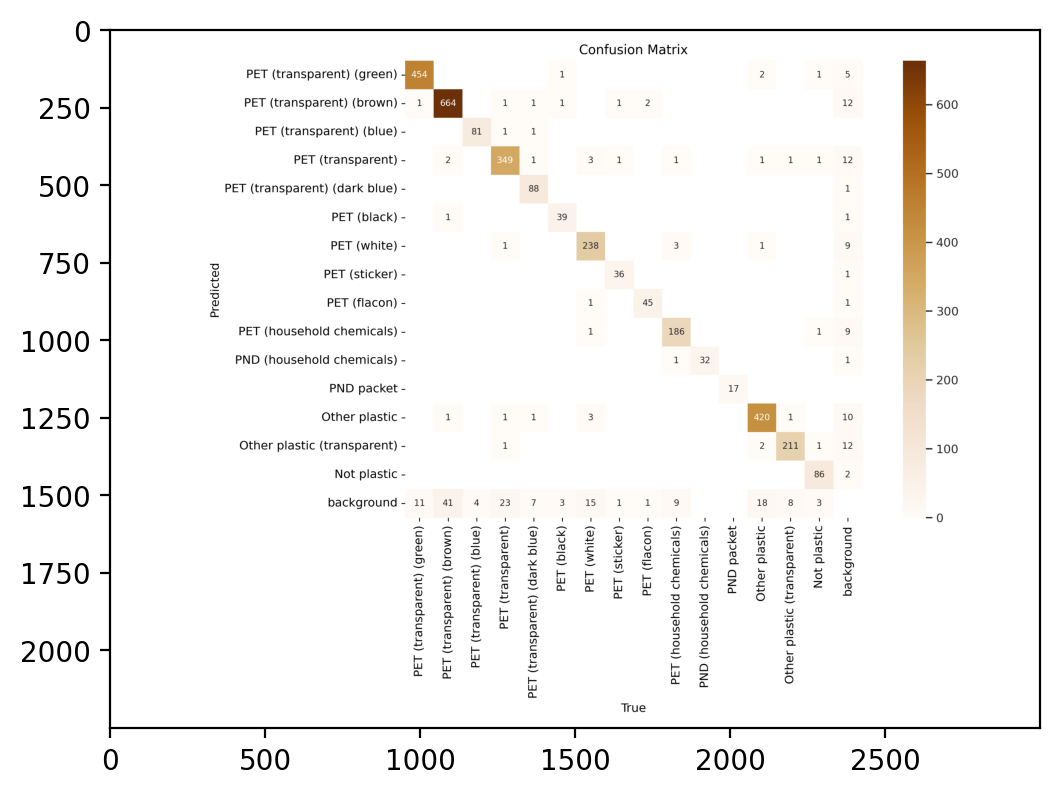

In [21]:
data_dir = '/kaggle/working/runs/detect/train'
img_lst = ['F1_curve.png', 'PR_curve.png', 'confusion_matrix.png', 'labels_correlogram.jpg', 'results.png', 'val_batch0_labels.jpg']

for image in img_lst:
    img_dir = os.path.join(data_dir, image)
    img = cv2.imread(img_dir)
    plt.figure(figsize=(6,6), dpi= 200)
    plt.imshow(img)

В процессе обучения были обучены различные архитектуры и модели задач детекции:

- Первой моделью стала Faster R-CNN, был содздан класс Dataset для загрузки и преобразования данных, к данным был применен Dataloader для разделения данных на батчи, обучение этой модели не привило ни к какому результату.
  
- Вследствие этого была выбрана другая архитектура - YoLo, для начала была взята модель YoLo8, после обучения на 30 эпохах модель показала неплохой результат на тесте weighted mean = 0.8146. Обучалась модель без 'пустых' изображений(т.е изобажения с пропусками в bbox и category_id не влючались в обучающую выборку). Далее в обучающую выборку были включены изображения без объектов, что повысило качество модели.
- В качестве основной модели была взяла YoLo11, были опробовано обучение с аугментацией и без нее, в результате чего было выявлено отсутствие больших различий в метрике, но в целях уменьшения затрат ресурсов было принято решение обучения без аугментации. Значительно улучшило метрику изменение входных размеров изображений от базовых 640 до (1024,768), вследстивии этого изменения и обучения модели на 120 эпохах была получена наилучшая метрика weighted mean = 0.873

## Предсказание на тесте

In [22]:
#Загрузка весов лучшей модели
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

#Создание директории для предсказаний
output_path = '/kaggle/working/yolo_data/test/predictions'
os.makedirs(output_path, exist_ok=True)

test_images = [os.path.join(output_test_images, img) for img in os.listdir(output_test_images)]

#Подготовка CSV-файла для результатов
csv_file = '/kaggle/working/yolo_data/test/predictions/submission.csv'
csv_columns = ['file_name', 'bbox']


with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_columns)
    
    #Обработка изображений по батчам, чтобы сэкономить паямть и ускорить процесс
    batch_size = 16
    for i in range(0, len(test_images), batch_size):
        batch = test_images[i:i + batch_size]
        
        #Предсказание
        results = model(batch)

        #Извлечение результатов 
        for j, result in enumerate(results):

            #Координаты центров, высота и ширина
            boxes = result.boxes.xywh.cpu().numpy()
            #Уверенность
            confs = result.boxes.conf.cpu().numpy()  
            #Класс
            classes = result.boxes.cls.cpu().numpy()
            
            #Извлечение имени текущего изображения
            img_name = os.path.basename(batch[j])
            #Список для параметров этого изображения
            file_bboxes = []
            
            
            for box, conf, cls in zip(boxes, confs, classes):
                #Меняем обратно номера классов, чтобы они соответсвовали изначальным
                cls += 1
                
                #Меняем формат праметров рамки на изначальный
                x_center, y_center, width, height = box
                x_left = (x_center - width / 2)
                y_top = (y_center - height / 2)
                
                #Создаем список и добавляем его в общий список для этого изображения, чтобы одной картинке соответстовала одна строка CSV-файла
                bbox = [cls, conf, x_left, y_top, width, height]
                file_bboxes.append(bbox)
            
            #Записываем в файл
            writer.writerow([img_name, file_bboxes])

        #Чистим память
        del results, boxes, confs, classes
        gc.collect()


0: 768x1024 1 PET (black), 2 PET (household chemicals)s, 1 Other plastic, 2 Not plastics, 8.5ms
1: 768x1024 1 PET (transparent), 1 Other plastic (transparent), 8.5ms
2: 768x1024 2 PET (transparent) (green)s, 1 PET (transparent), 8.5ms
3: 768x1024 3 PET (transparent) (brown)s, 1 PET (transparent), 1 PET (transparent) (dark blue), 1 Other plastic (transparent), 8.5ms
4: 768x1024 1 Other plastic, 8.5ms
5: 768x1024 1 PET (transparent) (brown), 4 Other plastics, 8.5ms
6: 768x1024 1 PND (household chemicals), 1 PND packet, 8.5ms
7: 768x1024 1 PET (transparent) (brown), 1 PET (transparent), 1 PET (transparent) (dark blue), 8.5ms
8: 768x1024 1 PET (transparent) (green), 1 PET (transparent) (brown), 1 PET (white), 2 PET (household chemicals)s, 1 Other plastic, 1 Other plastic (transparent), 8.5ms
9: 768x1024 1 PET (transparent) (green), 2 PET (transparent) (brown)s, 1 PET (transparent), 1 Other plastic, 8.5ms
10: 768x1024 (no detections), 8.5ms
11: 768x1024 1 PET (transparent) (dark blue), 1 O

## Заключение
В ходе соревнования была разработана модель, способная определять различные типы мусора на сортировочном конвейере мусороперерабатывающего завода.

Первый шаг - Изучение теории: история создания архитектур, решающих задачи детекции, типы архитектур и их принципы работы, метрика оценки качества модели.

Второй шаг - Загрузка данных: в ходе загрузки происходило первичное ознакомление с данными.

Третий шаг - Предобработка и исследовательский анализ: была изчуена структура данных, были выведены пример изображения и соответсвующих ему класса и параметров рамки, были обнаружены пропущенные значения в колонках, что означало отсутствие на изображение каких-либо объектов, в ходе процесса обучения и валидации результатов было принято решение оставить эти данные, так как они полезны для модели.

Четверый шаг - Подготовка данных: были созданы директории для данных, в которые были разделены тренировочные, валидационные и тестовые выборки. Далее был создан файла конфигурации в формате YAML для модели YoLo.

Пятый шаг - Обучение модели: в ходе работы были протестированы различные модели и их гиперпараметры. В результате лучшую метрику показала модель YoLo11 с imgsz=(1024,768) и обучением на 120 эпохах.

Шестой шаг - Тестирование: подготовка CSV-файла и предсказание на тестовых данных, в результате была получена метрика mAP=0.873